In [1]:
import sys
import sklearn
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
# Read track.csv into a pandas dataframe object
def load_tracks_data(csv_path):
    return pd.read_csv(csv_path)

In [3]:
# Load dataset
tracks = load_tracks_data('tracks.csv')

In [4]:
# Convert the release date to integers
tracks['release_date'] = tracks['release_date'].apply(lambda x:x[:4]).astype("int")

In [5]:
# Filter out tracks released in 2020
tracks = tracks[tracks['release_date'] == 2021]

In [6]:
# Encode the name of artists 
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
tracks["artists"] = encoder.fit_transform(tracks["artists"])

In [7]:
# Delete useless features
tracks = tracks.dropna()
tracks = tracks.drop(columns = ['id', 'name','id_artists','release_date'])

In [8]:
# Shuffle the dataset to avoid bias
from sklearn.utils import shuffle
tracks = shuffle(tracks)
tracks.reset_index(inplace=True,drop=True)

In [9]:
# Devide the dataframe to features and the label
X = tracks.drop(columns = ['popularity'])
y = tracks[['popularity']]
feature_name = X.columns.values.tolist()

In [10]:
# Convert popularity to boolean value by using threshold
from sklearn.preprocessing import Binarizer
T = tracks.describe().iat[5,0]
bi = Binarizer(threshold = T)
y = bi.transform(y)

In [11]:
# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()                                                                                               
X = scaler.fit_transform(X) 

<BarContainer object of 15 artists>

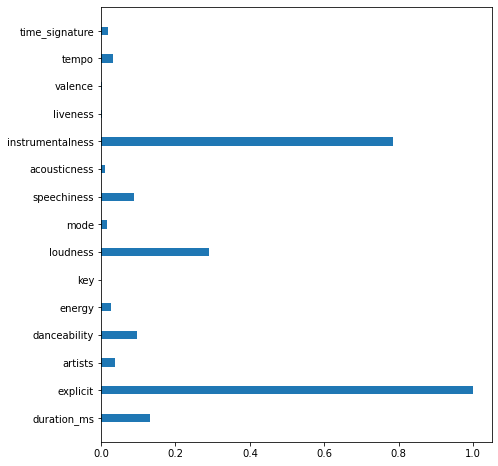

In [12]:
# plot feature scores
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
selector = SelectKBest(f_classif, k=4)
selector.fit(X, y.ravel())
scores = -np.log10(selector.pvalues_)
scores /= scores.max()

X_indices = np.arange(X.shape[-1])
plt.figure(figsize=(7,8))
plt.bar(x = 0, bottom = X_indices, height = .3, width = scores,orientation = "horizontal",
        label=r'Univariate score ($-Log(p_{value})$)', tick_label=feature_name)

In [13]:
# Univariate Feature Selection
X = SelectKBest(f_classif, k=12).fit_transform(X, y.ravel())

C:\Users\18697\anaconda3\envs\driving\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [14]:
# Parameter Optimization using Grid Search
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

tuned_parameters_svc = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

tuned_parameters_mlp = {"hidden_layer_sizes": [(100,), (100, 30), (50, 50)],
                            "max_iter": [3000],
                             "activation": ['relu','logistic'],
                       "solver": ['adam']}


clf = GridSearchCV(SVC(), tuned_parameters_svc)
clf.fit(X_train, y_train.ravel())

print("Best parameters set of svm found on development set:")
print(clf.best_params_)

clf = GridSearchCV(MLPClassifier(), tuned_parameters_mlp)
clf.fit(X_train, y_train.ravel())

print("Best parameters set of mlp found on development set:")
print(clf.best_params_)

Best parameters set of svm found on development set:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


C:\Users\18697\anaconda3\envs\driving\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\18697\anaconda3\envs\driving\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters set of mlp found on development set:
{'activation': 'relu', 'hidden_layer_sizes': (100, 30), 'max_iter': 2000, 'solver': 'adam'}


In [16]:
# Initialize the model
svm = SVC( kernel ="rbf", C = 1000, gamma = 0.001, probability = True)
mlp = MLPClassifier(hidden_layer_sizes=(100,30),activation='relu',max_iter=3000, solver ='adam',random_state=3)

In [17]:
from sklearn.metrics import plot_roc_curve,auc
from sklearn.metrics import precision_recall_fscore_support
from numpy import interp
from sklearn.model_selection import KFold

In [18]:
# Use K-fold cross-validation as evaluation criteria
kf = KFold(n_splits = 5)

In [19]:
clf = [svm, mlp]

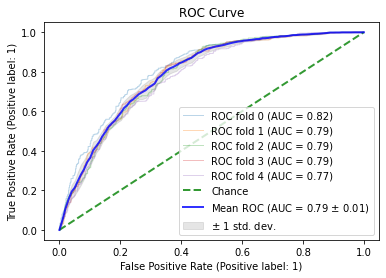

Precision:  0.751414378802495 
 Recall:  0.6709182937615765 
 Fscore:  0.7086424595867159 
 Accuracy:  0.7191494509726424 
 Std dev of accuracy:  0.014912300171555221


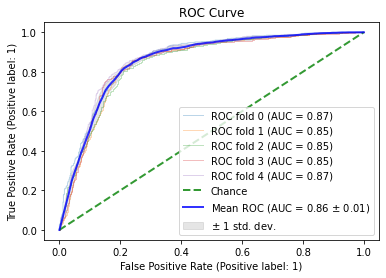

Precision:  0.8076678203897595 
 Recall:  0.8018896292552267 
 Fscore:  0.8045832290641517 
 Accuracy:  0.8017830087813973 
 Std dev of accuracy:  0.006899997413348139


In [21]:
# Evaluate two models
for model in clf:
    tprs = []
    aucs = []
    scores = [[],[],[],[]]
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, ax = plt.subplots()

    for i,(train_index,test_index) in enumerate(kf.split(X, y)):
        model.fit(X[train_index], y[train_index].ravel())
    
        y_pred = model.predict(X[test_index])
        score_temp = precision_recall_fscore_support(y[test_index], y_pred)
        for index in range(0,3):
            scores[index].append(score_temp[index][0])
        scores[3].append(model.score(X[test_index], y[test_index]))
                               
        viz = plot_roc_curve(model, X[test_index], y[test_index],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
    title="ROC Curve")
    ax.legend(loc="lower right")
    plt.show()

    print("Precision: ", np.mean(scores[0]),"\n",
         "Recall: ", np.mean(scores[1]), "\n",
         "Fscore: ", np.mean(scores[2]), "\n",
         "Accuracy: ", np.mean(scores[3]), "\n",
         "Std dev of accuracy: ", np.std(scores[3], ddof = 1))

In [22]:
# Filter out the unlabeled instances from the pool
def Filter(sorted_list, batch_size, unknown_indexes):
    anno_batch = []
    
    for i in sorted_list:
        if batch_size == 0:
            break      
        elif i in unknown_indexes:
            anno_batch.append(i)
            batch_size -= 1
        else:
            continue
            
    return anno_batch

In [23]:
# Strategies of Uncertainty Sampling
def RS(proba, batch_size, unknown_indexes):   
    return np.random.choice(unknown_indexes,batch_size,replace=False)

def LC(proba, batch_size, unknown_indexes):
    sorted_list = np.argsort(np.max(proba,axis=1))
    return Filter(sorted_list, batch_size, unknown_indexes)

def Margin(proba, batch_size, unknown_indexes):
    sorted_proba = np.sort(proba,axis=1)
    sorted_list = np.argsort(sorted_proba[:,-1]-sorted_proba[:,-2])  
    return Filter(sorted_list, batch_size, unknown_indexes)

In [52]:
# Define the batch size and the total rounds
batch_size = 10
max_rounds = 200

In [ ]:
strategies = {"RS":RS,"LC":LC, "Margin" : Margin}
results = {"RS":[],"LC":[], "Margin":[]}
iterations = {"RS":[],"LC":[], "Margin":[]}
init_labeled = 24

for index,(pool_index,test_index) in enumerate(kf.split(X, y)):
    
    X_pool = X[pool_index]
    y_pool = y[pool_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    for type0 in strategies:
    
        train_indexes = list(range(init_labeled))
        unknown_indexes = list(range(init_labeled, len(X_pool)))

        clf = svm
        
        learning_rate = 1
    
        for i in range(max_rounds - 1):   
                    
            X_train = X_pool[train_indexes]
            y_train = y_pool[train_indexes]
        
            clf.fit(X_train,y_train.ravel())
            prec = clf.score(X_test,y_test)
            
            if(index == 0):
                results[type0].append(prec)
            else:
                results[type0][i] += prec
                
            
        
            proba = clf.predict_proba(X_pool)
            stategy0 = strategies[type0]      
            anno_batch = stategy0(proba,batch_size, unknown_indexes)
    
            for j in anno_batch:
                unknown_indexes.remove(j)
                train_indexes.append(j) 
            
for type0 in strategies:
    for i in range(len(results[type0])):
        results[type0][i] /= 5

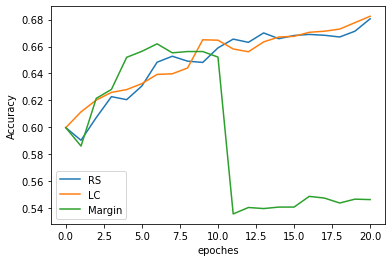

In [47]:
pd.DataFrame(results).plot()
plt.ylabel("Accuracy")
plt.xlabel("epoches")
plt.show()